# Survival SVM

In [1]:
pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import RepeatedKFold, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read the preprocessed file
brca = pd.read_csv('/content/drive/My Drive/3799/brca.csv')

In [5]:
y_df = brca.iloc[:,:2]
x = brca.iloc[:,2:]

In [6]:
# Convert the DataFrame to a structured array
y = np.empty(len(y_df), dtype=[('status', bool), ('time', float)])

# Populate the structured array
y['status'] = y_df.iloc[:, 0].astype(bool)
y['time'] = y_df.iloc[:, 1].astype(float)

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y['status'])

In [8]:
from sklearn.decomposition import PCA

# Perform PCA on the training set
pca = PCA(n_components=0.99)  # Retain 99% of the variance
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

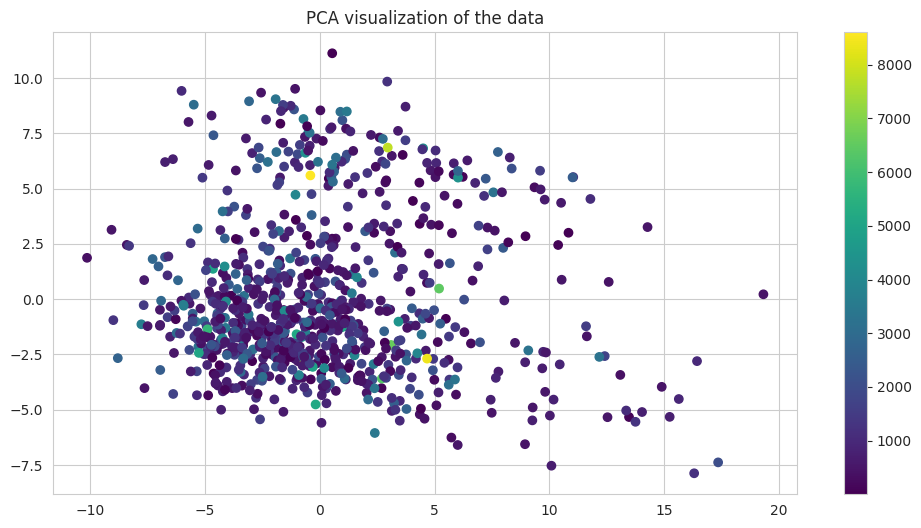

In [26]:
# Visualize dimension reduction results
plt.figure(figsize=(12, 6))
# component versus survival time
plt.scatter(x_train[:,0], x_train[:,1],c=pd.DataFrame(y_train, columns=['status', 'time']).iloc[:,1], cmap='viridis', marker='o')
plt.colorbar()
plt.title('PCA visualization of the data')
plt.show()

In [27]:
print(x_train.shape)
print(x_test.shape)

(863, 771)
(216, 771)


In [28]:
# rank ratio = 0
# As a regression problem: the model learns to directly predict the (log) survival time.
estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=42)

In [29]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["status"], y["time"], -prediction)
    return result[0]

In [30]:
param_grid = {"alpha": 2.0 ** np.arange(-12, 13, 2)}

# 5 repetitions of 5-fold cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model, n_jobs=-1, refit=False, cv=cv)

In [31]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x_train, y_train)

In [32]:
print("Best parameters:", gcv.best_params_)
print("Best C-index:", round(gcv.best_score_, 3))

Best parameters: {'alpha': 0.0009765625}
Best C-index: 0.605


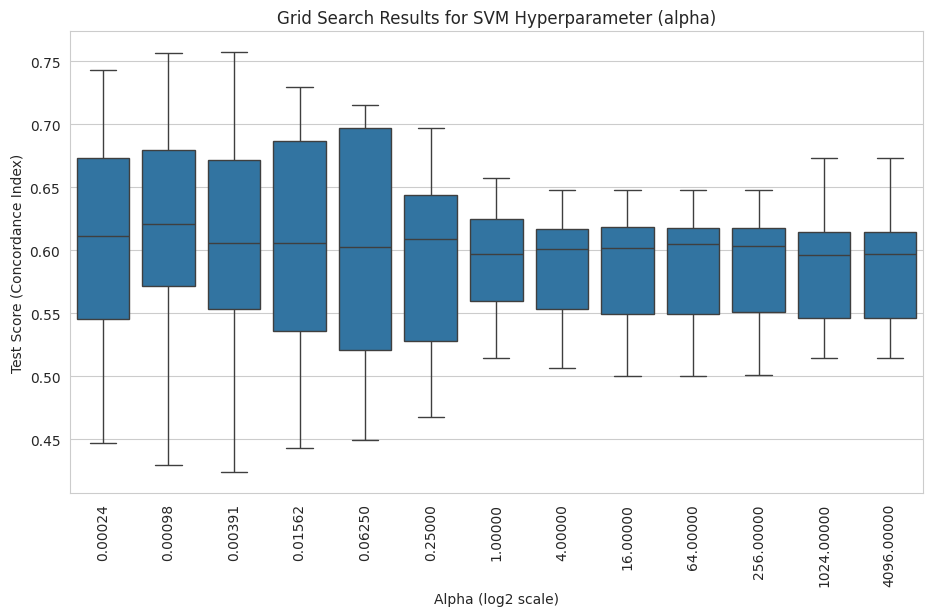

In [33]:
def plot_performance(gcv):
    cv_results = gcv.cv_results_
    param_values = cv_results['param_alpha'].data.astype(float)
    test_scores = cv_results['mean_test_score']
    n_splits = len(cv_results['split0_test_score'])  # Accessing the number of splits

    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []

    for i, param_value in enumerate(param_values):
        name = f'{param_value:.5f}'
        order.append(name)
        for j in range(n_splits):
            vs = cv_results[f"split{j}_test_score"][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)

    df = pd.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

    plt.title('Grid Search Results for SVM Hyperparameter (alpha)')
    plt.xlabel('Alpha (log2 scale)')
    plt.ylabel('Test Score (Concordance Index)')
    plt.show()

plot_performance(gcv)

In [34]:
train_cindex_scores = []
test_cindex_scores = []

for _ in range(20):
    estimator.set_params(**gcv.best_params_)
    estimator.fit(x_train, y_train)

    # Evaluate the model on the train set
    train_pred = estimator.predict(x_train)
    train_cindex = concordance_index_censored(y_train["status"], y_train["time"], -train_pred)
    train_cindex_scores.append(train_cindex[0])

    # Evaluate the model on the test set
    test_pred = estimator.predict(x_test)
    test_cindex = concordance_index_censored(y_test["status"], y_test["time"], -test_pred)
    test_cindex_scores.append(test_cindex[0])

In [35]:
print("Mean C-index on train set:", round(np.mean(train_cindex_scores),3))
print("Mean C-index on test set:", round(np.mean(test_cindex_scores),3))

Mean C-index on train set: 0.761
Mean C-index on test set: 0.572


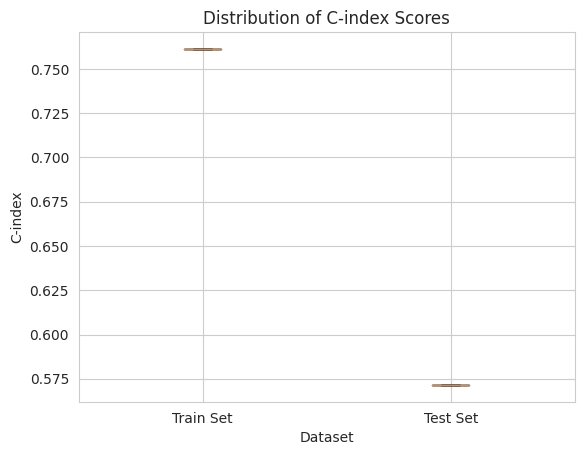

In [36]:
# Create boxplot
plt.boxplot([train_cindex_scores, test_cindex_scores], labels=['Train Set', 'Test Set'])
plt.xlabel('Dataset')
plt.ylabel('C-index')
plt.title('Distribution of C-index Scores')
plt.show()